# Overview

This notebook walks through the process of disaggregating DRB demand data to the nodes of interest. 



In [12]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Geospatial libraries
import geopandas as gpd

# Data acquisition libraries
from pynhd import NLDI, NHDPlusHR, WaterData

# Step 0: Load data

Load Pywr-DRB nodes.

Load Pywr-DRB USGS data sources, and unpack the list where multiple gauges are listed for a single node. 


In [2]:
### Load data
# Constants
crs = 4386

# Pywr nodes
nodes = pd.read_csv('../model_data/drb_model_nodes.csv', sep = ',')
drb_boundary = gpd.read_file('DRB_shapefiles/drb_bnd_polygon.shp')
drb_boundary = drb_boundary.to_crs(crs)


In [3]:
# Get long-lat at all nodes of interest
reservoir_nodes = nodes.loc[nodes.type=='storage']

stem_nodes = ['link_delTrenton', 'link_delMontague', 'link_delLordville', 
               'link_outletAssunpink', 'link_outletSchuylkill', 'link_outletChristina']

other_nodes = nodes.loc[nodes.name.isin(stem_nodes)]

physical_nodes = pd.concat([reservoir_nodes, other_nodes], axis=0)
physical_nodes.reset_index(inplace=True)

# Pull just long,lat and make numpy
loc_data = physical_nodes[['long', 'lat']].to_numpy()

In [4]:
# Start a new DF to store data
node_geo_data = pd.DataFrame()
node_geo_data['node'] = physical_nodes.name
node_geo_data['long'] = physical_nodes.long
node_geo_data['lat'] = physical_nodes.lat

# Step 1: Get basin geometries

Use the station number (with a leading '0') to find each basin.

In [5]:
nldi = NLDI()
comid_data = nldi.comid_byloc(coords = list(loc_data[0:,:]))

In [9]:
# Store data
node_geo_data['comid'] = comid_data.comid
node_geo_data['reachcode'] = comid_data.reachcode

# Get basin geometry
node_basins = nldi.get_basins(list(node_geo_data['comid'].values), fsource='comid', split_catchment = True)

node_geo_data['geometry'] = node_basins.reset_index().geometry
node_geo_data = gpd.GeoDataFrame(node_geo_data, geometry=node_geo_data['geometry'])
node_geo_data.set_crs(4326)
node_geo_data.to_crs(crs)

node_geo_data.head(3)

,node,long,lat,comid,reachcode,geometry
0,reservoir_cannonsville,-75.374620,42.065872,2614136,02040101005432,"POLYGON ((-75.25965 42.07860, -75.25913 42.075..."
1,reservoir_pepacton,-74.965531,42.073603,1748727,02040102000078,"POLYGON ((-74.97852 42.05968, -74.98468 42.064..."
2,reservoir_neversink,-74.643266,41.821286,4147432,02040104000138,"POLYGON ((-74.63683 41.78541, -74.63870 41.787..."


<AxesSubplot:>

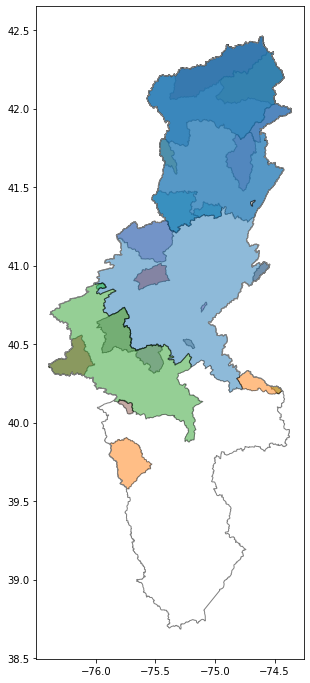

In [24]:
# Visualize
ax =node_geo_data.plot(column = 'node', edgecolor = 'black', alpha = 0.5, figsize=(8,12))
drb_boundary.plot(ax=ax, color = 'none', edgecolor = '0.5')

In [8]:
# Export
node_geo_data.to_file("./DRB_shapefiles/node_basin_geometries.shp")

In [26]:
node_geo_data.iloc[:,:-1].to_csv('./node_basin_ids.csv', index=False)

In [27]:
node_geo_data

,node,long,lat,comid,reachcode,geometry
0,reservoir_cannonsville,-75.374620,42.065872,2614136,02040101005432,"POLYGON ((-75.25965 42.07860, -75.25913 42.075..."
1,reservoir_pepacton,-74.965531,42.073603,1748727,02040102000078,"POLYGON ((-74.97852 42.05968, -74.98468 42.064..."
2,reservoir_neversink,-74.643266,41.821286,4147432,02040104000138,"POLYGON ((-74.63683 41.78541, -74.63870 41.787..."
3,reservoir_wallenpaupack,-75.184230,41.460825,2742586,02040103000072,"POLYGON ((-75.34810 41.21746, -75.34580 41.221..."
4,reservoir_prompton,-75.327680,41.589961,2739772,02040103000041,"POLYGON ((-75.37506 41.62698, -75.37673 41.629..."
5,reservoir_shoholaMarsh,-74.968660,41.392015,4150530,02040104000280,"POLYGON ((-75.00919 41.29979, -75.00722 41.303..."
6,reservoir_mongaupeCombined,-74.755352,41.478898,4151958,02040104001520,"POLYGON ((-74.75527 41.47872, -74.76210 41.475..."
7,reservoir_beltzvilleCombined,-75.638495,40.851266,4188143,02040106008081,"POLYGON ((-75.63874 40.84416, -75.63752 40.847..."
8,reservoir_fewalter,-75.720849,41.113559,4186391,02040106008098,"POLYGON ((-75.66168 41.09080, -75.66691 41.096..."
9,reservoir_merrillCreek,-75.102810,40.727174,2588031,02040105000293,"POLYGON ((-75.11627 40.70567, -75.11465 40.708..."
